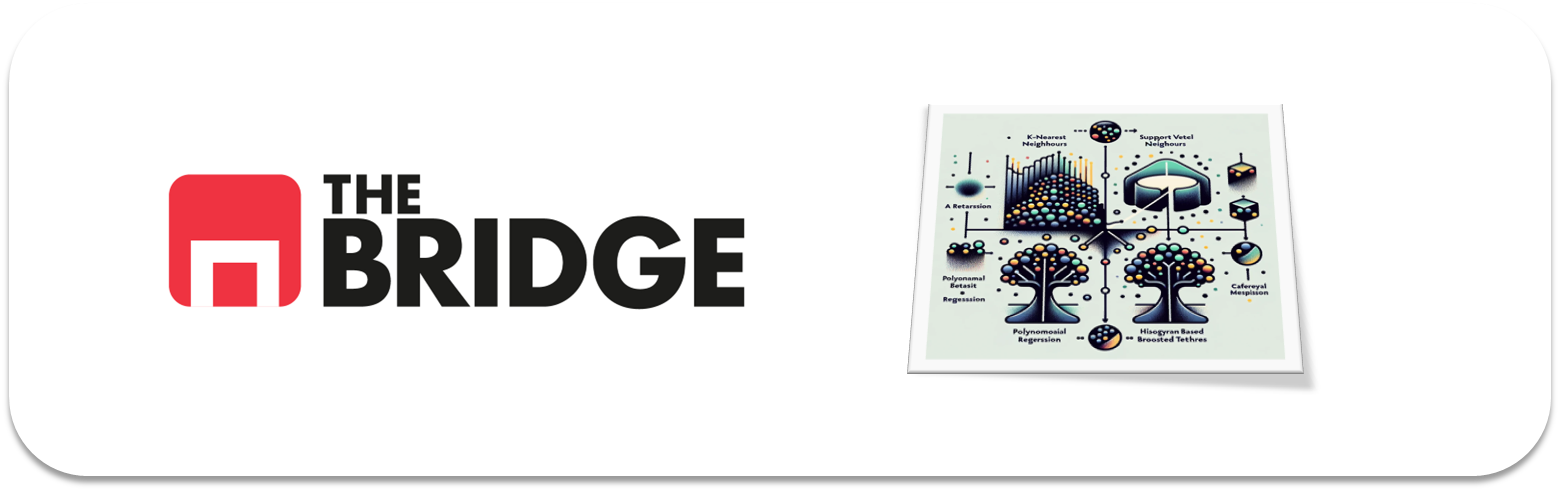

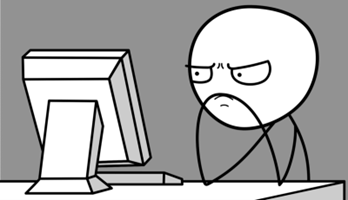

Para hacer un **repaso a los problemas de clasificacion con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Equilibrado del train set  
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

### El problema

La unidad oncológica del hospital de Madison, Wisconsin, está trabajando en un tratamiento muy prometedor sobre el cáncer de mama. Desgraciadamente es un tratamiento con efectos secundarios y todavía excesivamente caro, pero cuya efectividad es extraordinaria si se aplica en las primeras etpas o incluso antes de haberlo desarrollado. 

En este sentido, la univeridad quiere disponer de un modelo que le permita detectar potenciales pacientes pero con un alto nivel de acierto en detectar quien puede tener cáncer para no aplicar el tratamiento a personas que no fueran a desarrollarlo y por tanto no sólo perder dinero, sino también, y más importante causar problemas a esas personas. 

Nos piden trabajar sobre datos que ya tienen, y que pueden obtener facilmente de cualquier futuro aspirante a las pruebas y ensayos con el tratamiento, de pacientes que desarrollaron y no el cáncer. Sobre ese dataset quieren que les proporcionemos el mejor modelo de predicción de quién desarrollará o no el cáncer y que cumpla con las expectativas del párrafo anterior.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bootcampviztools import *

from lightgbm import LGBMClassifier

from scipy.stats import f_oneway

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from toolbox_ML import *

from xgboost import XGBClassifier

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué tipo de problema de clasificación vamos a resolver? ¿Qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

- *Vamos a resolver un problema de clasificación binaria*

- *La métrica que creo que es la más conveniente sería:*
    - ***F1-score** ya que es el balance entre precisión y recall dado que nos interesa tanto detectar correctamente a quienes tendrán cáncer como evitar tratar a quien no lo desarrollará*
    
- *Podemos usar una Regresión Logística, Random Forest, XGBoost...*

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [100]:
df_cancer = pd.read_csv('./data/wisconsin_cancer.csv', sep='|')
df_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374


In [101]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
 11  radius_se               569 non-null    float64
 12  texture_se              569 non-null    float64
 13  perimeter_se            569 non-null    float64
 14  area_se                 569 non-null    fl

In [102]:
describe_df(df_cancer)

,COL_N,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst
0,DATA_TYPE,object,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,UNIQUE_VALUES,2,456,479,522,539,474,537,537,542,...,541,533,507,498,545,457,511,514,544,411
3,CARDIN (%),0.35,80.14,84.18,91.74,94.73,83.3,94.38,94.38,95.25,...,95.08,93.67,89.1,87.52,95.78,80.32,89.81,90.33,95.61,72.23


In [103]:
tipifica_variables(df_cancer, 10, 20.0)

,nombre_variable,tipo_sugerido
0,diagnosis,Binaria
1,radius_mean,Numérica Continua
2,texture_mean,Numérica Continua
3,perimeter_mean,Numérica Continua
4,area_mean,Numérica Continua
5,smoothness_mean,Numérica Continua
6,compactness_mean,Numérica Continua
7,concavity_mean,Numérica Continua
8,concave points_mean,Numérica Continua
9,symmetry_mean,Numérica Continua


In [104]:
df_cancer['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

*Descripción de cada variable*:

1. diagnosis: Es la variable objetivo, indica si el cáncer es maligno (M) o benigno (B).

**Medias de las características (indicadores "mean"):**

2. `radius_mean`: Promedio del radio de las células tumorales, calculado como la media de las distancias del centro a los bordes.
3. `texture_mean`: Desviación estándar de los valores de escala de grises en la imagen de las células, mide la variabilidad en la textura de la superficie celular.
4. `perimeter_mean`: Promedio del perímetro de las células tumorales.
5. `area_mean`: Promedio del área de las células.
6. `smoothness_mean`: Promedio de la suavidad, que refleja qué tan uniformes son los bordes de las células.
7. `compactness_mean`: Promedio de la compactación de las células, calculado como el perímetro² / área - 1.0.
8. `concavity_mean`: Promedio de la concavidad, mide la extensión de las áreas cóncavas de los bordes de las células.
9. `concave points_mean`: Promedio del número de puntos cóncavos en los bordes de las células.
10. `symmetry_mean`: Promedio de la simetría de las células.
11. `fractal_dimension_mean`: Promedio de la dimensión fractal de los bordes de las células, que mide la irregularidad del borde.

**Error estándar de las características (indicadores "se"):**

12. `radius_se`: Error estándar del radio de las células.
13. `texture_se`: Error estándar de la textura.
14. `perimeter_se`: Error estándar del perímetro.
15. `area_se`: Error estándar del área.
16. `smoothness_se`: Error estándar de la suavidad.
17. `compactness_se`: Error estándar de la compactación.
18. `concavity_se`: Error estándar de la concavidad.
19. `concave points_se`: Error estándar del número de puntos cóncavos.
20. `symmetry_se`: Error estándar de la simetría.
21. `fractal_dimension_se`: Error estándar de la dimensión fractal.

**Puntos "worst" (peores valores de las características):**

22. `radius_worst`: Valor más alto del radio entre todas las células del tumor.
23. `texture_worst`: Valor más alto de la textura entre todas las células.
24. `perimeter_worst`: Valor más alto del perímetro.
25. `area_worst`: Valor más alto del área.
26. `smoothness_worst`: Valor más alto de la suavidad.
27. `compactness_worst`: Valor más alto de la compactación.
28. `concavity_worst`: Valor más alto de la concavidad.
29. `concave points_worst`: Valor más alto del número de puntos cóncavos.
30. `symmetry_worst`: Valor más alto de la simetría.
31. `fractal_dimension_worst`: Valor más alto de la dimensión fractal.

*Todas las variables son numéricas continuas, no tienen nulos y la **Target** es `diagnosis` siendo una variable categórica binaria*

In [105]:
target = 'diagnosis'

NOTA: Para más información sobre el dataset el hospital nos redirige a esta [página web](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

### Ejercicio 3: Split

Haz el split en train y test.

In [106]:
train_set, test_set = train_test_split(df_cancer, test_size=0.2, random_state=42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución frecuencial de target brevemente.

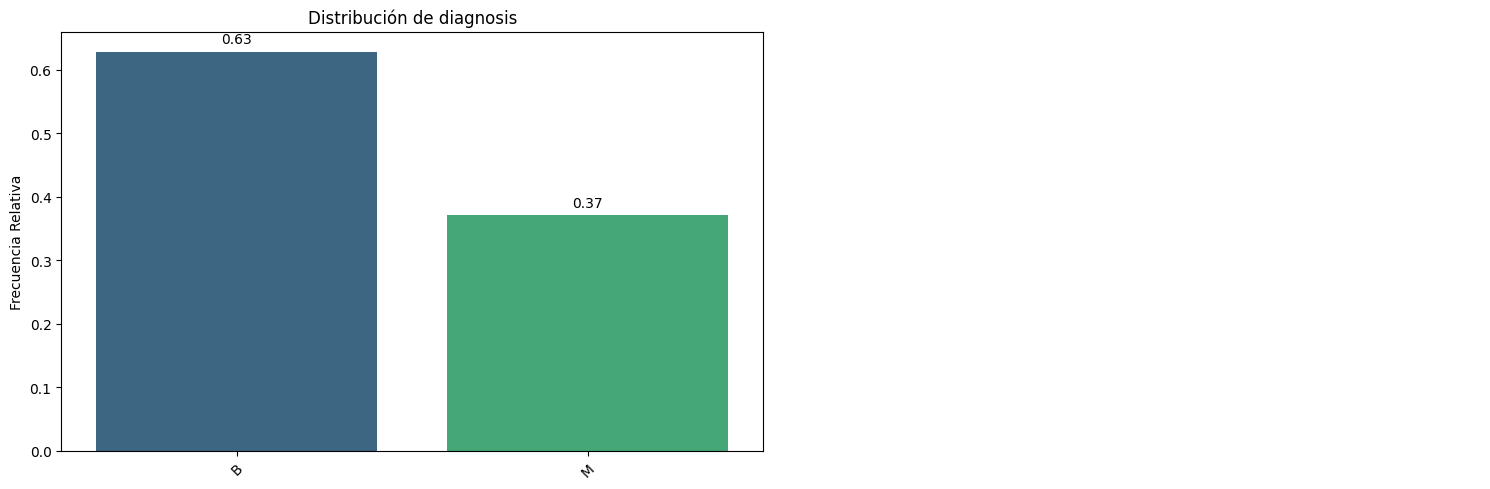

In [107]:
pinta_distribucion_categoricas(train_set, [target], relativa=True, mostrar_valores=True)

*El desequilibrio no es extremo pero sí podemos afirmar que las clases están desbalanceadas*

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, de forma que veamos las distintas distribuciones para cada clase (puedes emplear la libería gráfica que crees conveniente)

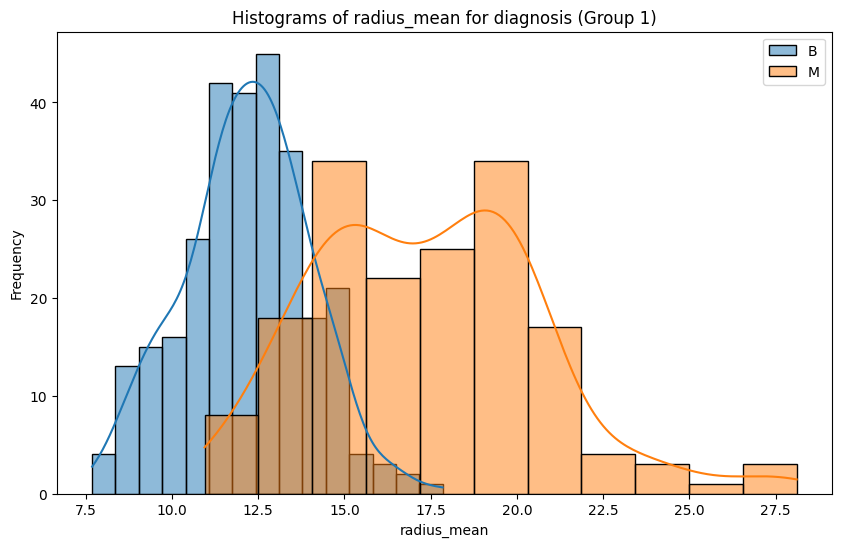

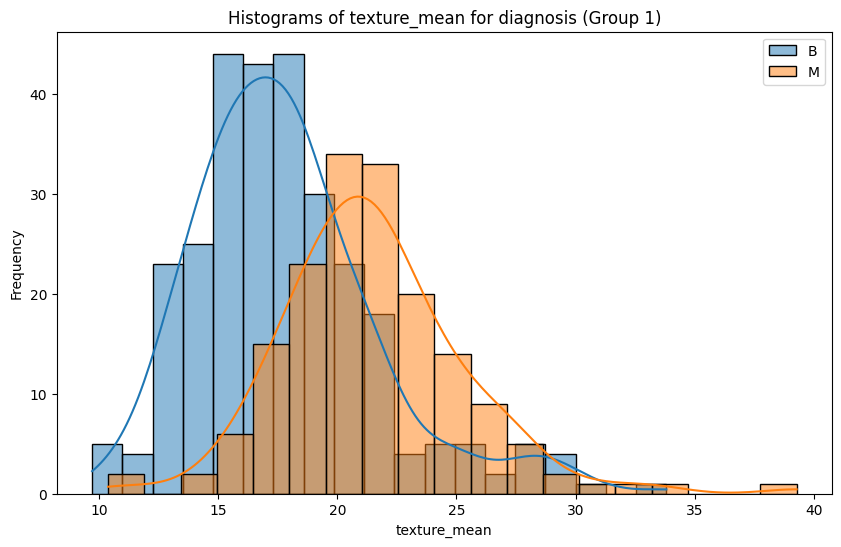

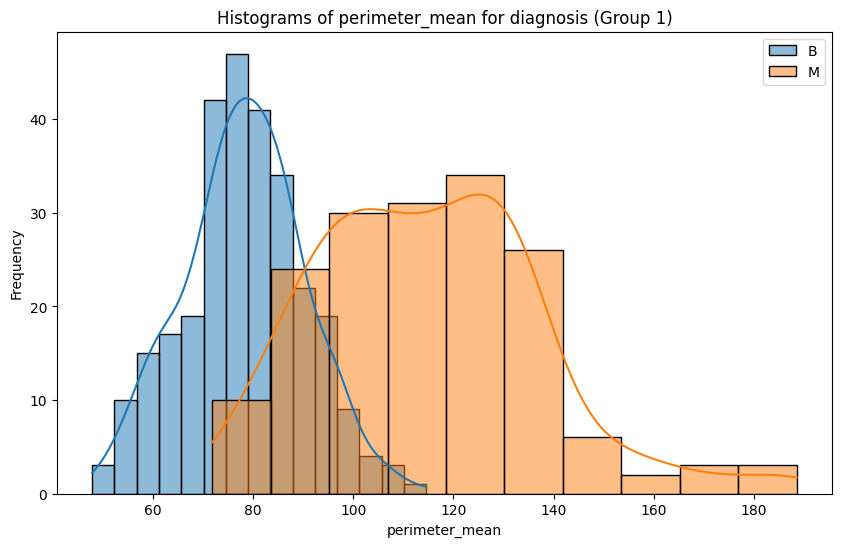

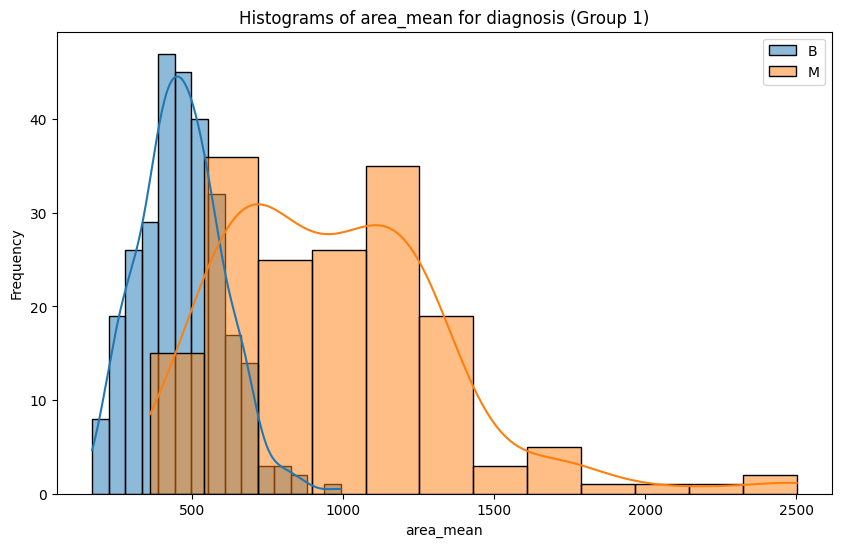

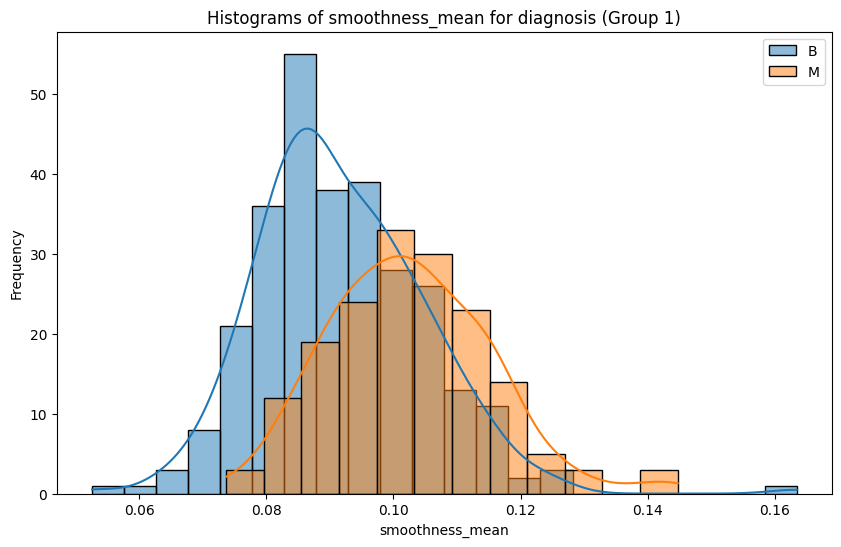

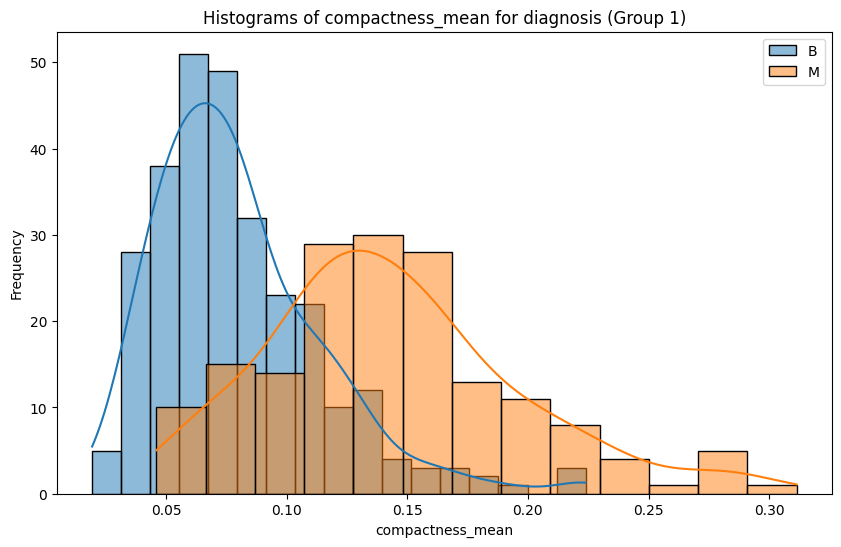

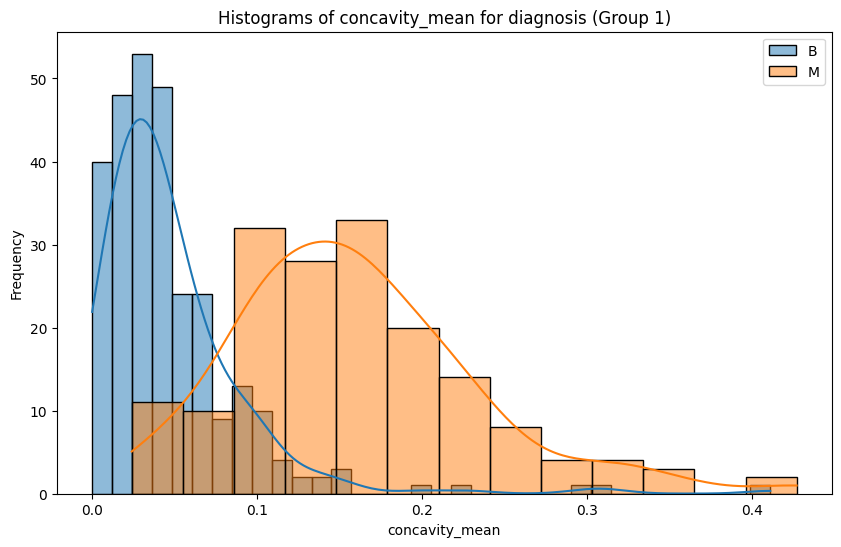

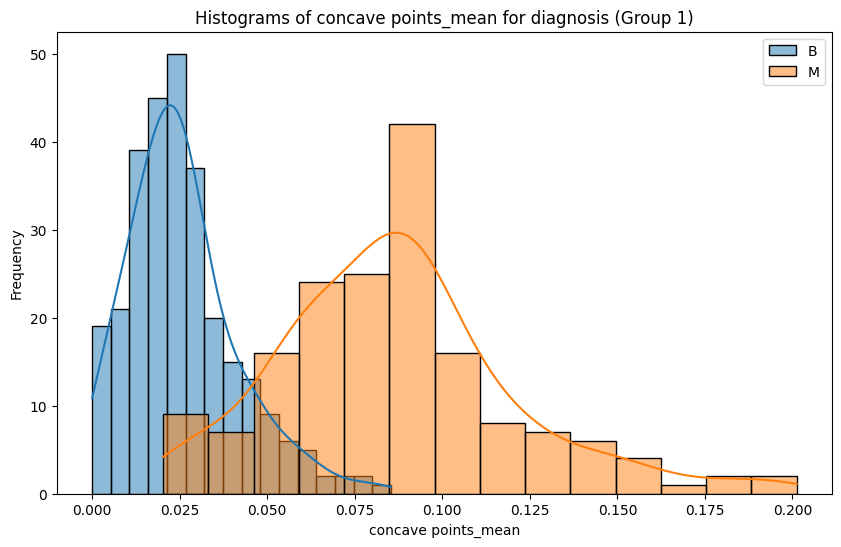

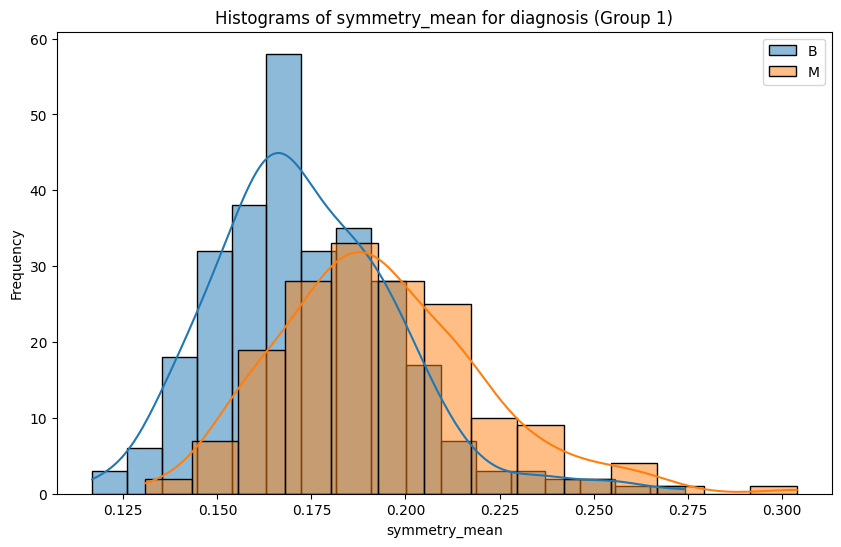

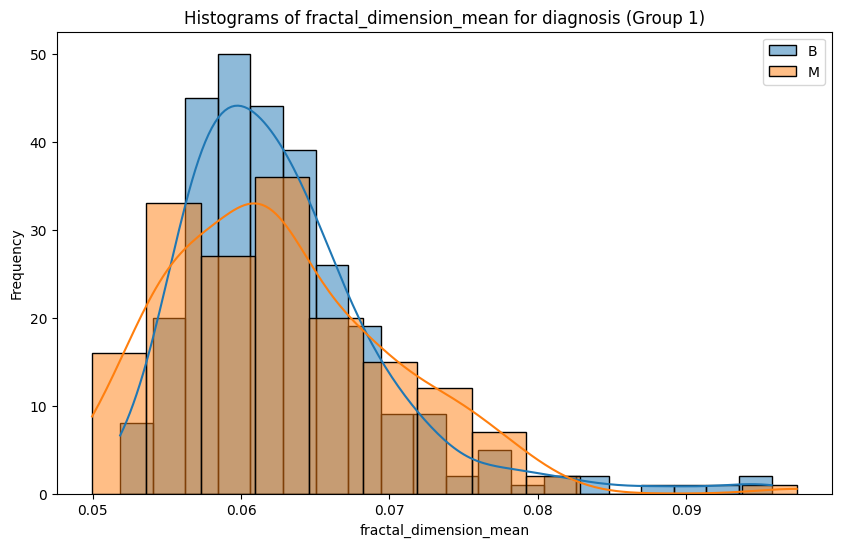

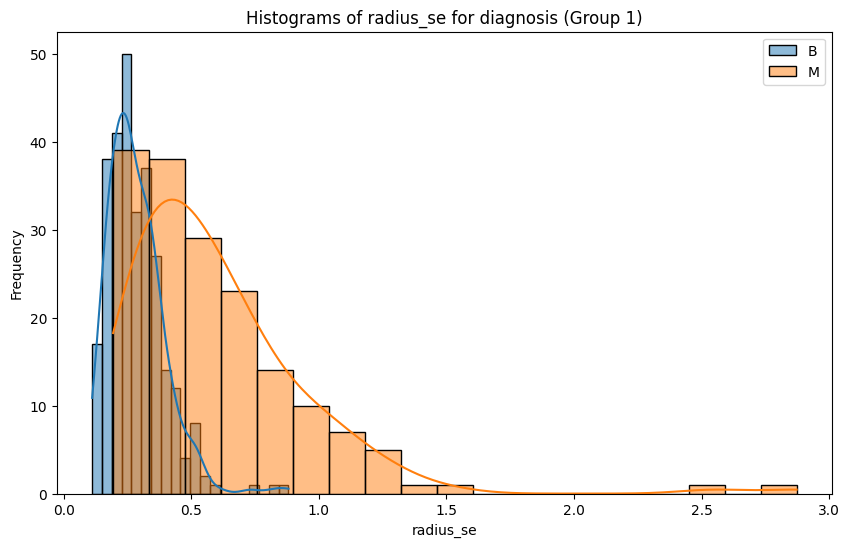

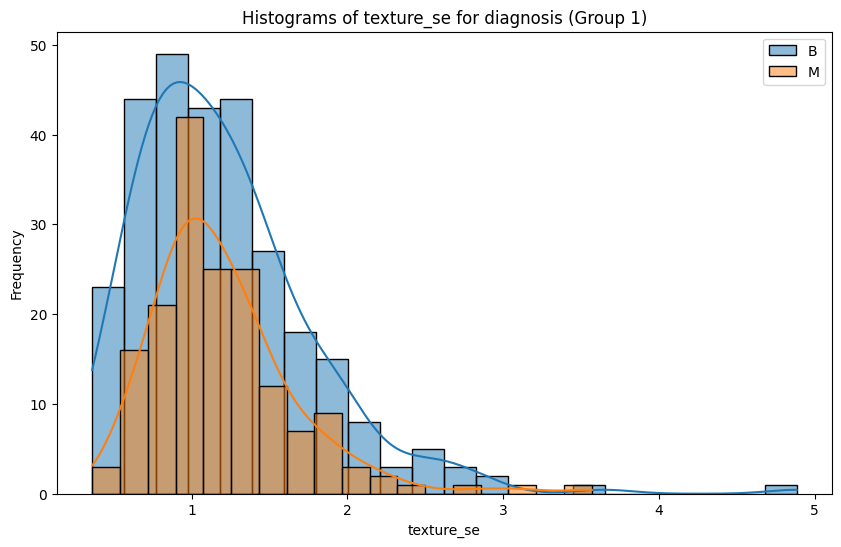

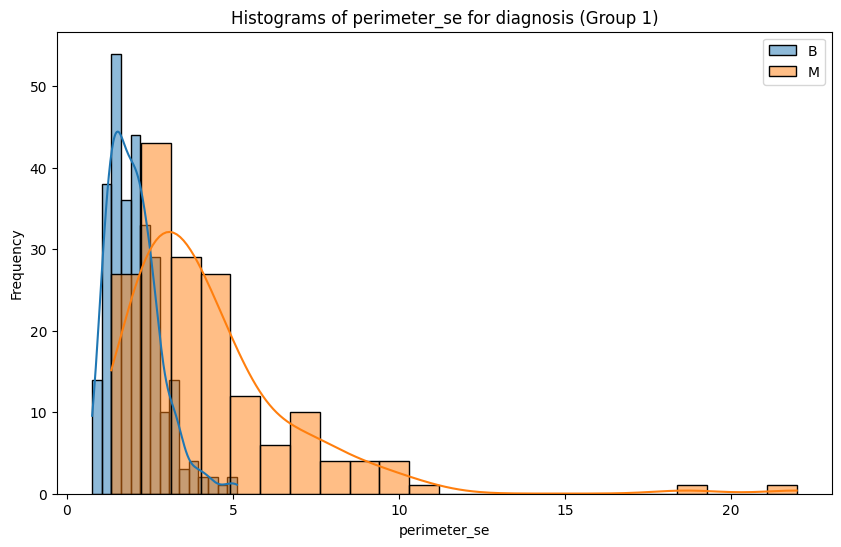

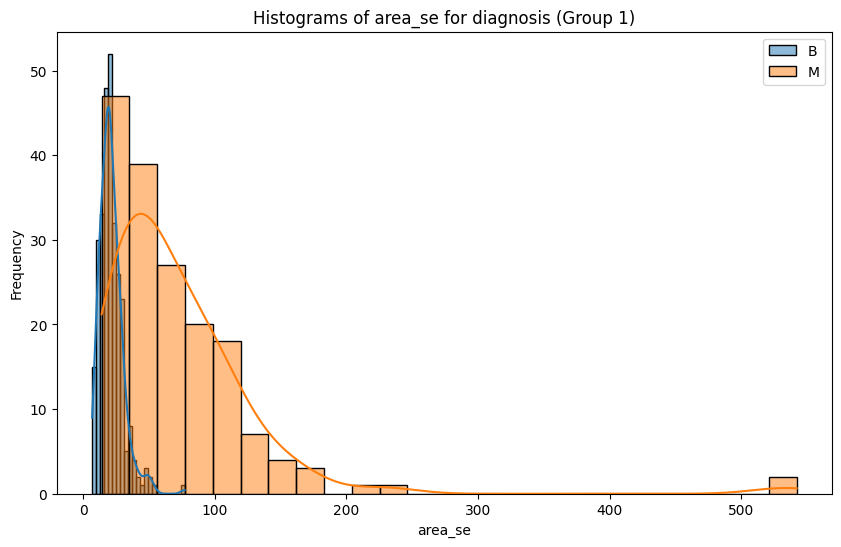

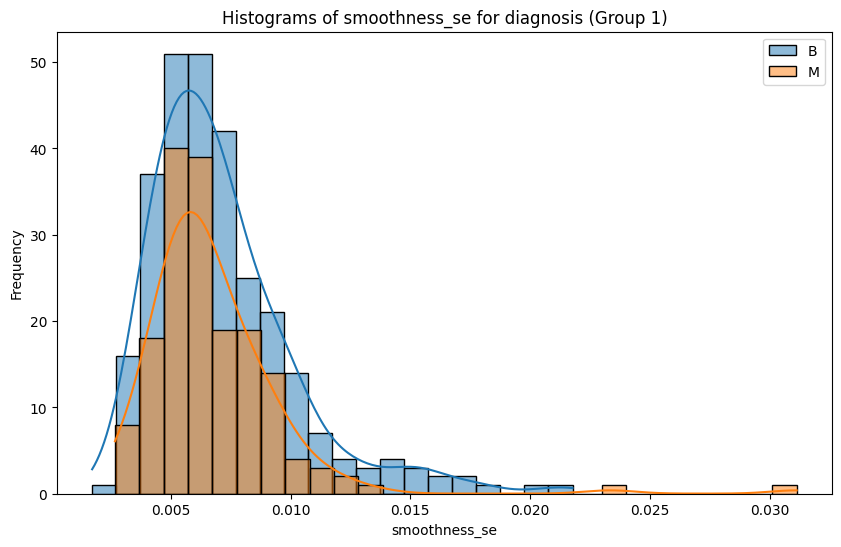

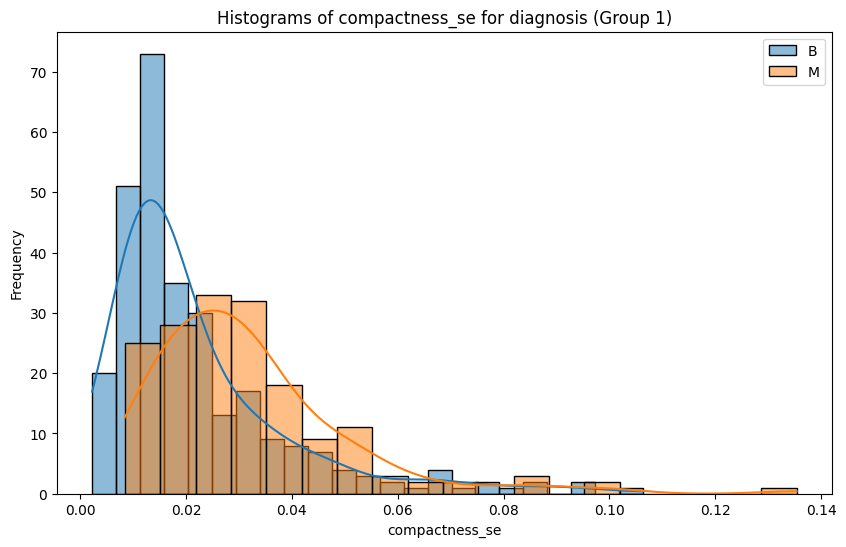

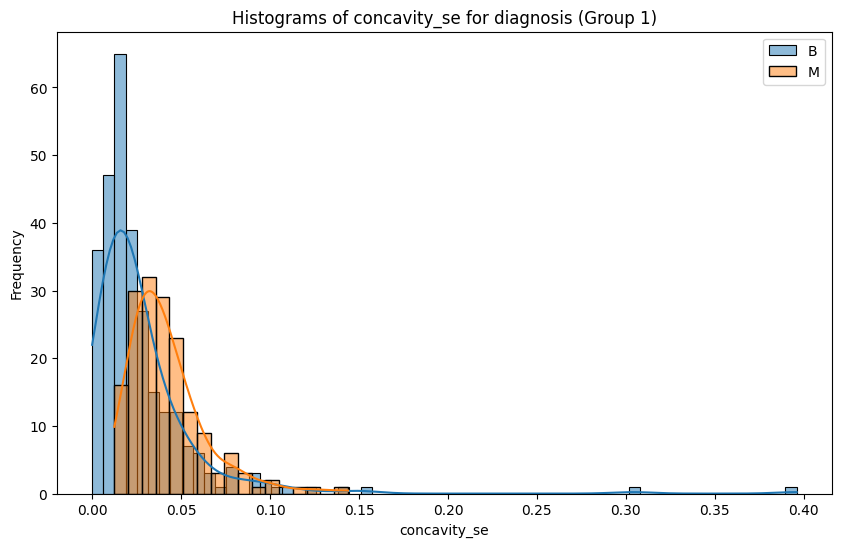

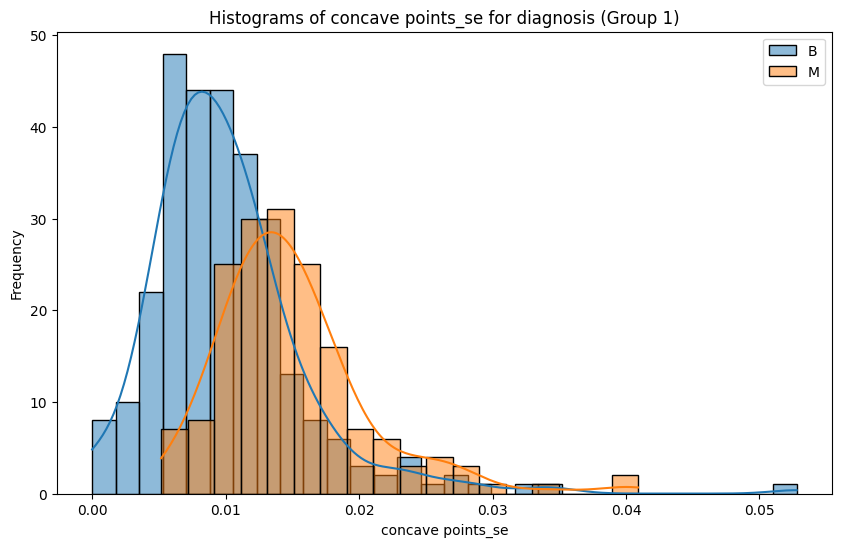

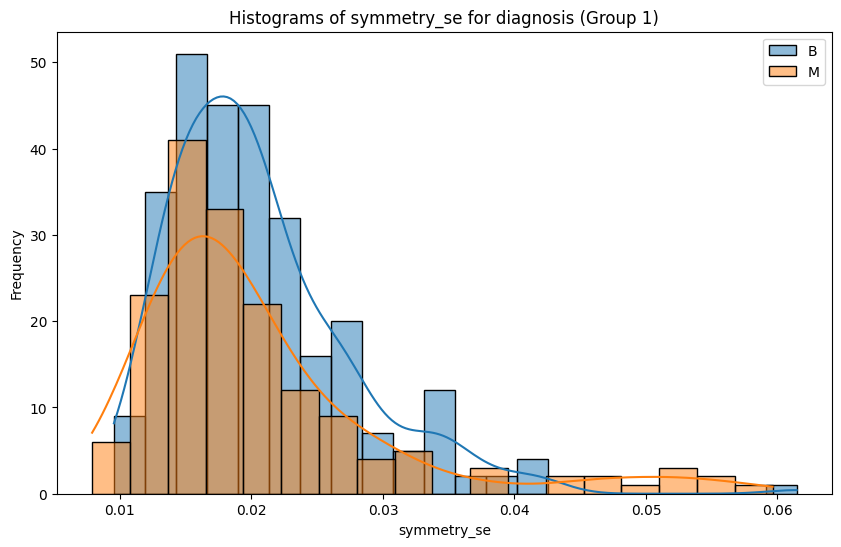

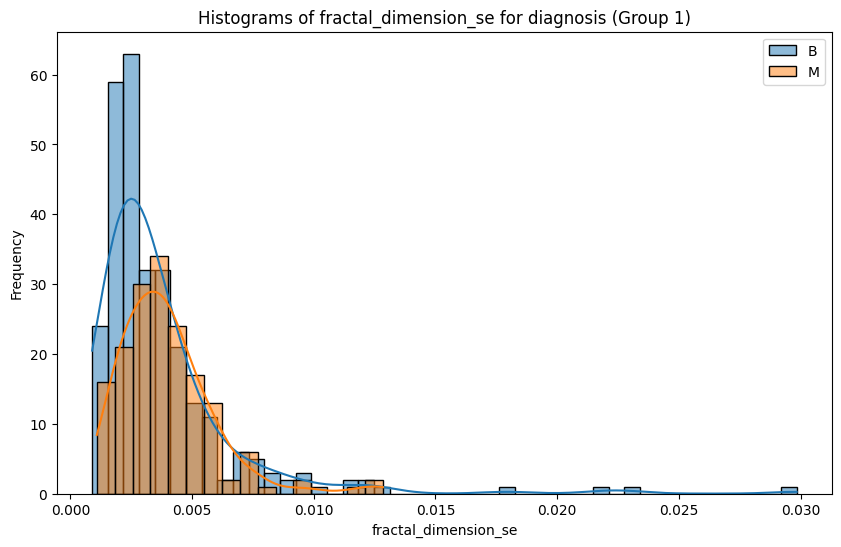

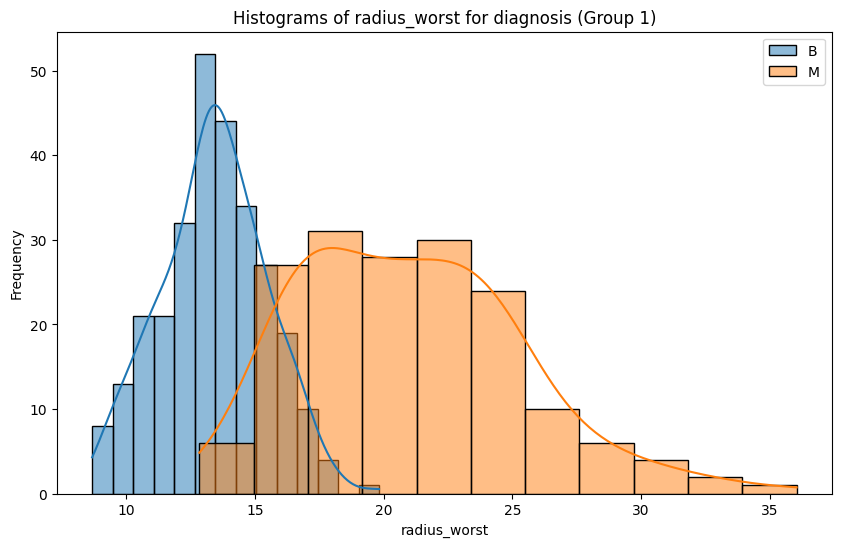

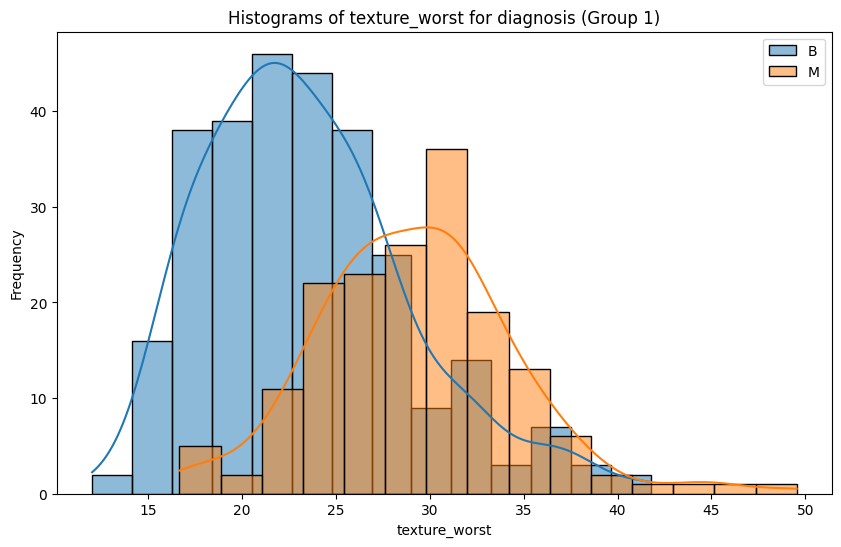

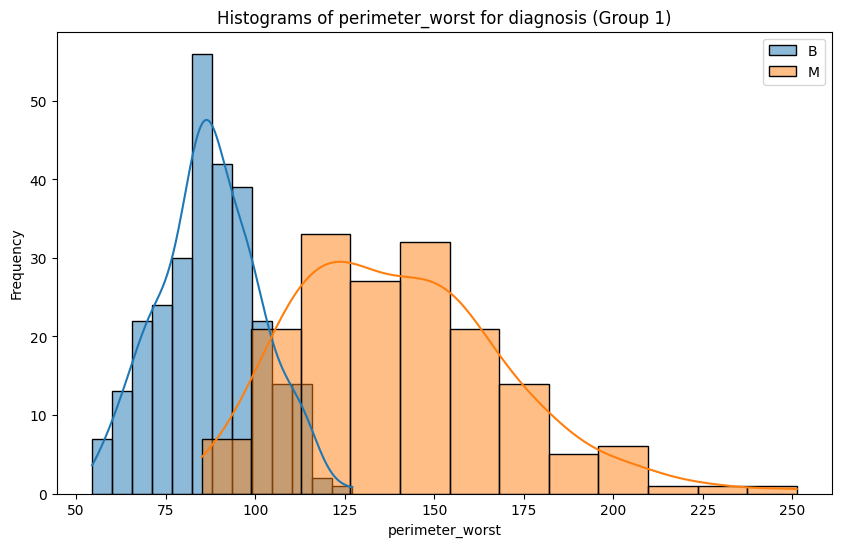

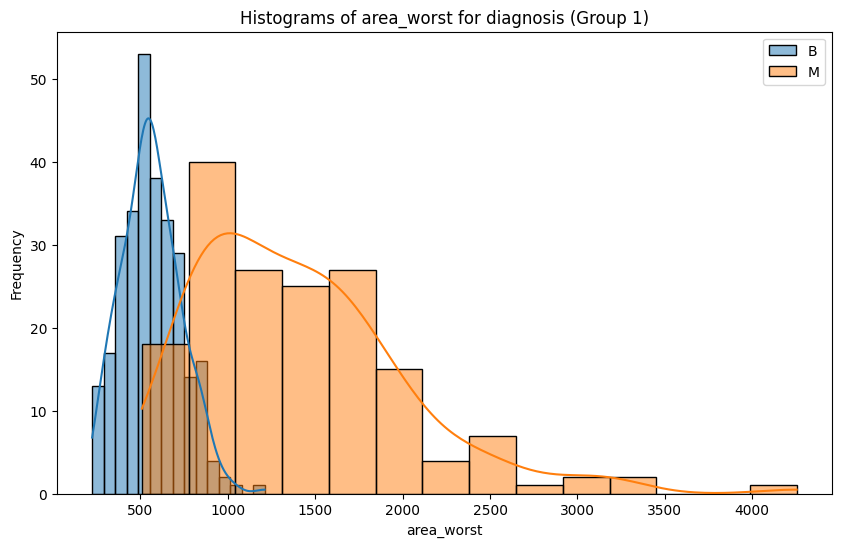

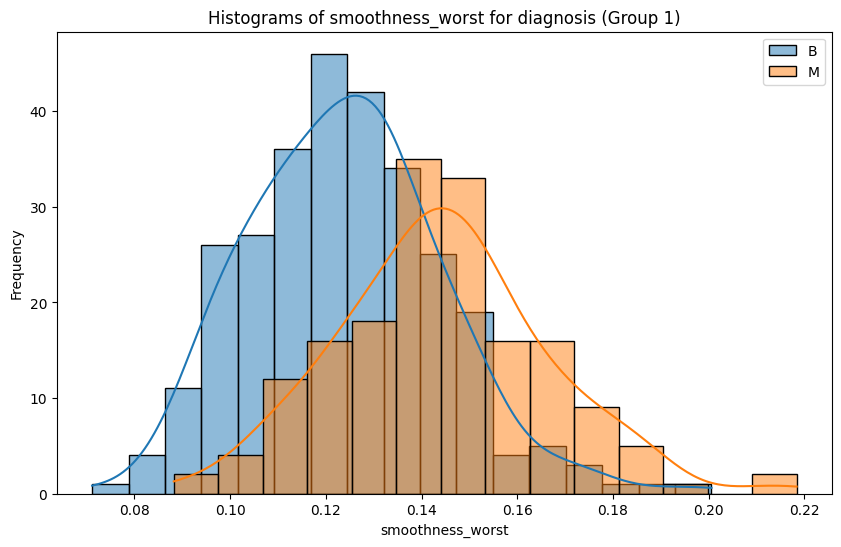

In [108]:
for col in train_set.columns:
    if col != target:
        plot_grouped_histograms(train_set, target, col, group_size=2)

*La mayayoría de las variables tienen una diferencia signficativa con la **Target** exceptuando `texture_se`, `smoothness_se` que tiene la misma distribución para los casos beningos y malignos*

*En este caso, voy a analizar la significancia de estas dos variables con la **Target** empleando el test ANOVA*

In [109]:
features_no = ['texture_se', 'smoothness_se']
grupos = train_set[target].unique()
for col in features_no:
    categoria = [train_set[train_set[target] == grupo][col] for grupo in grupos]
    _, p_val = f_oneway(*categoria)
    print(f'{col} --> {p_val}')


texture_se --> 0.9452937207832933
smoothness_se --> 0.2159194371937009


*Podemos concluir de que estas dos variables no tienen significancia con la **Target** ya que tienen un p-valor por encima del 0.05 por lo que confirmamos la hipótesis nula siendo esta que no están relacionadas entre sí*

*Por lo que, de momento, las **Features** serían las siguientes*

In [110]:
features = [col for col in train_set.columns if col != features_no and col != target]


### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [111]:
features #Creada en el apartado anterior

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst']

In [112]:
modelos = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier', 'XGBClassifier']

*Sí tendría que tratar las variables ya que algunos modelos son más sensibles que otro al escalados de las variables numéricas. Además, al normalizarlos ayuda a tener mejores predicciones.*

*En el caso de la variable objetivo, al ser categórica binaria, se debe de hacer una tranfomación a numérica refiriéndonos a 0 si es maligno (M) y 1 si es benigno(B)*

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [ ]:
# Primero vemos como están distribuidas las Features
#train_set[features].hist()
#plt.tight_layout()

In [ ]:
# Hay algunas que no necesitan tranformacion logaritmica por lo que las decarto
#no_log = ['radius_mean', 'texture_mean', 'smoothness_mean', 'symmetry_mean', 'texture_worst', 'smoothness_worst']
#features_log = [col for col in features if col != no_log]
#features_log

In [96]:
#train_set[features_log] = train_set[features_log].apply(lambda x: np.sqrt(x + 1))  # Agregar 1 para evitar errores con 0
#train_set[features_log] = np.log(train_set[features_log])

In [ ]:
#train_set[features_log].hist()
#plt.tight_layout()

In [46]:
# Hago lo mismo en el Test
#test_set[features_log] = test_set[features_log].apply(lambda x: np.sqrt(x + 1))  # Agregar 1 para evitar errores con 0

In [ ]:
#scaler = StandardScaler()

#train_set[features] = scaler.fit_transform(train_set[features])
#test_set[features] = scaler.transform(test_set[features])

#train_set[features].describe()

In [115]:
minmax = MinMaxScaler(feature_range=(0,1))
train_set[features] = minmax.fit_transform(train_set[features])
train_set[features].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.314738,0.320427,0.312720,0.207662,0.389221,0.288471,0.208290,0.239960,0.343826,0.269519,...,0.175620,0.082888,0.225307,0.236879,0.101076,0.276190,0.360226,0.267465,0.162115,0.409985
std,0.173163,0.144268,0.173012,0.152297,0.125693,0.179681,0.186195,0.189166,0.146756,0.151847,...,0.139745,0.081176,0.119229,0.152524,0.096290,0.175838,0.161650,0.169664,0.140848,0.156779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.196582,0.218465,0.193342,0.107226,0.299675,0.148997,0.068697,0.101093,0.241057,0.161858,...,0.078694,0.038182,0.145690,0.136773,0.045869,0.159966,0.240538,0.151314,0.072660,0.293622
50%,0.274695,0.303348,0.270736,0.163606,0.379074,0.245154,0.144189,0.166054,0.333689,0.242628,...,0.136450,0.066035,0.210267,0.202285,0.080020,0.229954,0.351812,0.219511,0.114877,0.405692
75%,0.394192,0.401589,0.397140,0.256243,0.468719,0.383261,0.310098,0.367271,0.422317,0.339933,...,0.225636,0.107487,0.277420,0.286274,0.124674,0.355676,0.470949,0.356667,0.200452,0.508592
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [116]:
#Hago lo mismo en el Test
test_set[features] = minmax.transform(test_set[features])


In [117]:
# Transformo la Target en numérica binaria
label_encoder = LabelEncoder()
train_set[target] = label_encoder.fit_transform(train_set[target])

train_set[target].value_counts()

diagnosis
0    286
1    169
Name: count, dtype: int64

In [118]:
# Hago lo mismo en el Test
test_set[target] = label_encoder.fit_transform(test_set[target])

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [119]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

### Ejercicio 9: Instanciación de modelos

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. Si quieres emplear la regresión logística es posible que tengas que utilizar un valor de max_iter para que el algoritmo converja.

In [24]:
modelos

['LogisticRegression',
 'RandomForestClassifier',
 'LGBMClassifier',
 'XGBClassifier']

In [120]:
log_reg = LogisticRegression(max_iter=1000)
random_tree = RandomForestClassifier(max_depth=7)
lgb = LGBMClassifier(verbose=-100)
xgb = XGBClassifier()

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea el recall_medio y usa scoring = "balanced acuracy". Escoge el modelo ganador.

In [121]:
metricas = {}
cv_log_reg = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='balanced_accuracy')
metricas['cv_log_reg'] = cv_log_reg
cv_random_tree = cross_val_score(random_tree, X_train, y_train, cv=5, scoring='balanced_accuracy')
metricas['cv_random_tree'] = cv_random_tree
cv_lgb = cross_val_score(lgb, X_train, y_train, cv=5, scoring='balanced_accuracy')
metricas['cv_lgb'] = cv_lgb
cv_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring='balanced_accuracy')
metricas['cv_xgb'] = cv_xgb

In [122]:
metricas

{'cv_log_reg': array([0.94592476, 0.94117647, 0.94711042, 0.93240454, 0.94117647]),
 'cv_random_tree': array([0.9762278 , 0.94711042, 0.96775026, 0.92956656, 0.94711042]),
 'cv_lgb': array([0.98275862, 0.96181631, 0.95614035, 0.96181631, 0.91769866]),
 'cv_xgb': array([0.99137931, 0.94711042, 0.98529412, 0.96181631, 0.94711042])}

In [123]:
mean_log_reg = metricas['cv_log_reg'].mean()
mean_random_tree = metricas['cv_random_tree'].mean()
mean_lgb = metricas['cv_lgb'].mean()
mean_xgb = metricas['cv_xgb'].mean()

mejor_modelo = max([('Log_reg', mean_log_reg), ('Random_tree', mean_random_tree), ('LGB', mean_lgb), ('XGB', mean_xgb)])
mejor_modelo

('XGB', 0.9665421159389345)

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "balance accuracy". Por otro lado, incluye en el grid, el hiperparámetro que permita que el modelo "compense" el desbalanceo del dataset de entrada, aunque este no lo tenga.

In [126]:
params_grid = {
    'n_estimators': np.arange(50,100,10),
    'max_depth': np.arange(2,10,1),
    'subsample': range(0,1),
    'colsample_bytree': range(0,1),
    'eta': range(0,1),
    'scale_pos_weight': [1, 5, 10, 20, 50]
}

xgb_grid = GridSearchCV(xgb, cv=5, param_grid=params_grid, scoring='balanced_accuracy')

xgb_grid.fit(X_train, y_train)

c:\Users\sorim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': range(0, 1), 'eta': range(0, 1),
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([50, 60, 70, 80, 90]),
                         'scale_pos_weight': [1, 5, 10, 20, 50],
                         'subsample': range(0, 1)},
             scoring='balanced_accuracy')

### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [127]:
y_pred = xgb_grid.predict(X_test)

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        71
           1       0.00      0.00      0.00        43

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



c:\Users\sorim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sorim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sorim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Ejercicio 13: Análisis de errores

Muestra la matriz de confusión con los porcentajes de precisión (emplea ConfusionMatrixDisplay.from_predictions con el argumento normalize con el valor adecuado). Haz un pequeño análisis.

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/cancer_pred" con la extesión apropiada.